In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.dates as mdates

In [44]:
df = pd.read_csv("timetable_peak.csv", sep=";", engine="python")
df_act = pd.read_csv("60_min_delay_03072025.csv", sep=";", engine="python")

# Rij 0 bevat de kleuren
kleuren = df.iloc[0].copy()

# Rij 1,2,3,… bevatten stations en tijden
df2 = df.iloc[1:].copy()

df2.rename(columns={"train_id": "station"}, inplace=True)

# Langformaat opbouwen
records = []

for col in df2.columns:
    if col == "station" or col.startswith("Unnamed"):
        continue

    kleur = kleuren[col]

    for _, row in df2.iterrows():
        station = row["station"]
        tijd = row[col]

        if isinstance(tijd, str) and ":" in tijd:
            records.append({
                "train_id": col,
                "station": station,
                "time": tijd,
                "color": kleur
            })

dataset = pd.DataFrame(records)
print(dataset.head())

  train_id              station   time color
0    NJ420         Bad Bentheim  07:41   Red
1    NJ420             Deventer  08:34   Red
2    NJ420             Deventer  08:37   Red
3    NJ420  Amersfoort Centraal  09:13   Red
4   ICE242         Bad Bentheim  07:51   Red


In [45]:
stations = {
    "Bad Bentheim": 0,
    "Oldenzaal": 15.4,
    "Hengelo Oost": 24.2,
    "Hengelo": 26.4,
    "Borne": 31.7,
    "Almelo de Riet": 39.2,
    "Almelo": 41,
    "Wierden": 45.6,
    "Rijssen": 53.3,
    "Holten": 60.8,
    "Deventer Colmschate": 75.4,
    "Snippeling Aansluiting": 77.3,
    "Deventer": 79.9,
    "Deventer aansluiting Noord": 80.4,
    "Twello": 84.6,
    "Apeldoorn Osseveld": 91.7,
    "Apeldoorn": 94.5,
    "Barneveld aansluiting": 122.1,
    "Hoevelaken": 132.2,
    "Amersfoort Centraal": 138.2
}

stations_te_plotten = [
    "Bad Bentheim", 
    "Oldenzaal",
    #"Hengelo Oost",
    "Hengelo",
    #"Borne",
    #"Almelo de Riet",
    "Almelo",
    #"Wierden",
    #"Rijssen",
    #"Holten",
    #"Deventer Colmschate",
    "Deventer",
    #"Twello",
    #"Apeldoorn Osseveld",
    "Apeldoorn",
    #"Hoevelaken",
    "Amersfoort Centraal"
]

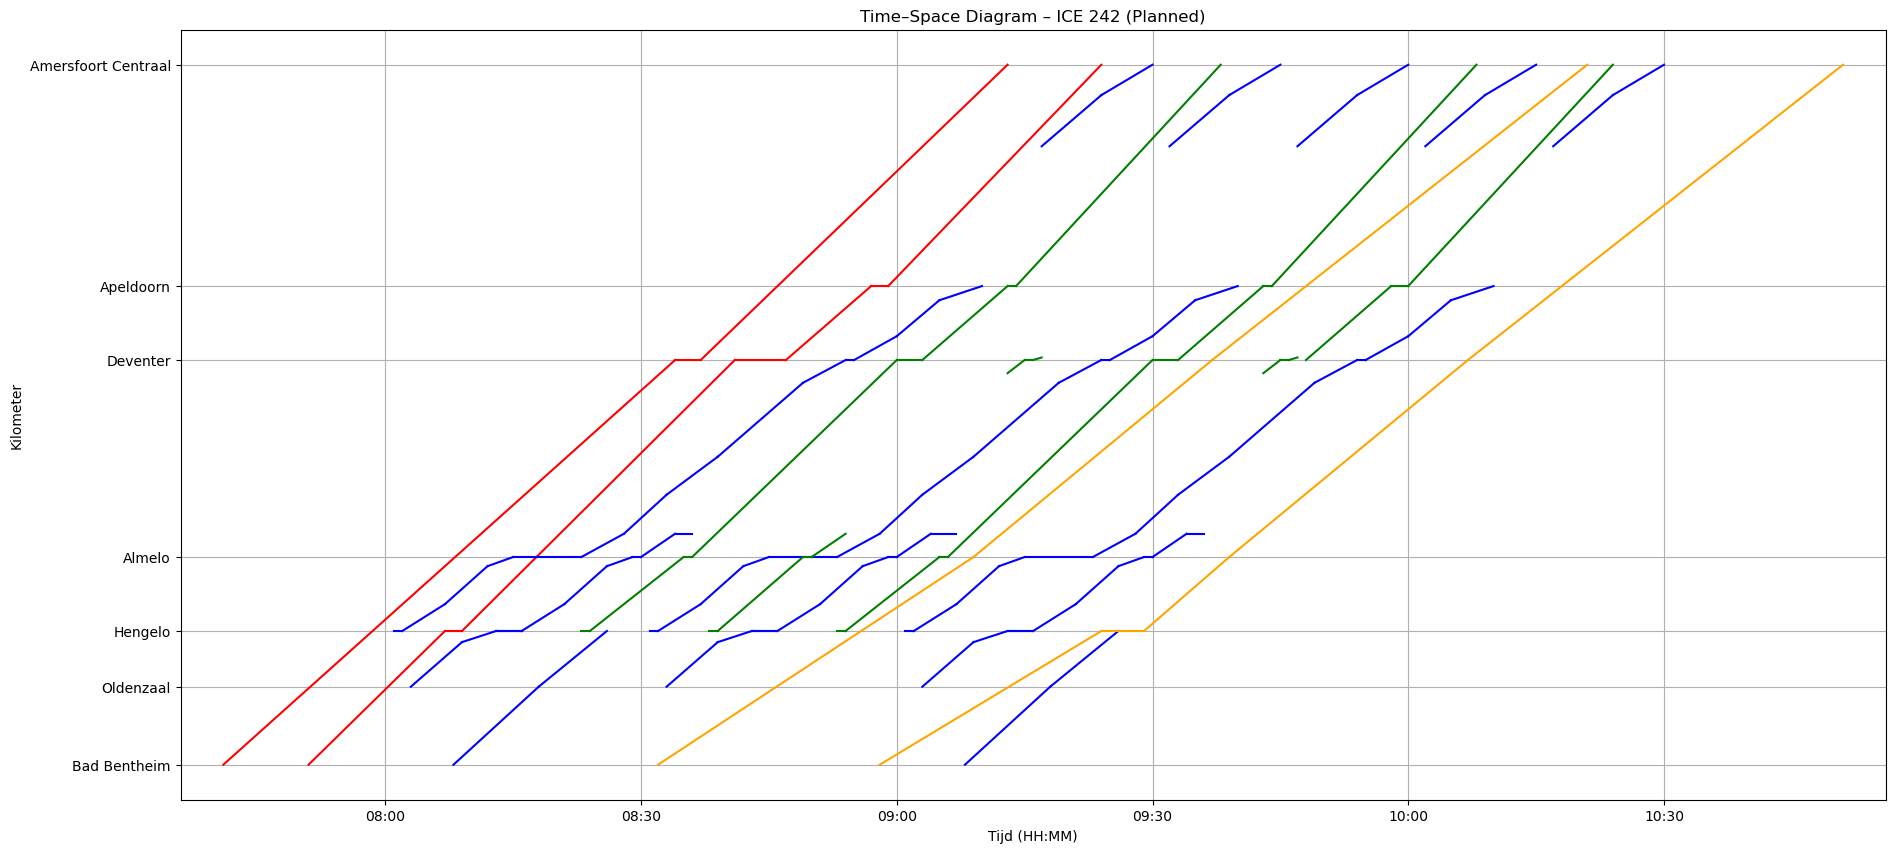

In [46]:
# ---------------------------------------
# 1. Helpers
# ---------------------------------------
def hhmm_to_abs_minutes(t):
    h, m = map(int, t.split(":"))
    return h * 60 + m

def build_segments_from_dataset(trein_data):
    points = []
    for station, t, _ in trein_data:
        if station not in stations:
            continue
        km = stations[station]
        pts = hhmm_to_abs_minutes(t)   # ◀️ GEEN mod 60 meer
        points.append((pts, km))

    points.sort()
    segments = []
    for i in range(len(points)-1):
        t1, km1 = points[i]
        t2, km2 = points[i+1]
        segments.append((t1, km1, t2, km2))
    return segments

def shift_segments(segments, dt):
    return [(t1+dt, km1, t2+dt, km2) for (t1, km1, t2, km2) in segments]

def km_at(t, t1, km1, t2, km2):
    return km1 + (km2 - km1) * (t - t1) / (t2 - t1)

def detect_conflicts(segmentsA, segmentsB, threshold=0.05):
    conflicts = []
    for (tA1, kmA1, tA2, kmA2) in segmentsA:
        for (tB1, kmB1, tB2, kmB2) in segmentsB:

            t_start = max(tA1, tB1)
            t_end   = min(tA2, tB2)
            if t_start >= t_end:
                continue

            ts = np.arange(t_start, t_end, 0.1)
            for t in ts:
                kmA = km_at(t, tA1, kmA1, tA2, kmA2)
                kmB = km_at(t, tB1, kmB1, tB2, kmB2)
                if abs(kmA - kmB) < threshold:
                    conflicts.append((t, kmA))
    return conflicts

def shift_time_abs_minutes(t, offset):
    return hhmm_to_abs_minutes(t) + offset


# ---------------------------------------
# 2. Plotfunctie voor één trein
# ---------------------------------------
def plot_trein(trein_data, offset=0):
    points_abs = []
    for station, t, color in trein_data:
        if station not in stations:
            continue
        km = stations[station]
        abs_min = shift_time_abs_minutes(t, offset)
        points_abs.append((abs_min, km, color))

    points_abs.sort()

    for i in range(len(points_abs)-1):
        t1, km1, color = points_abs[i]
        t2, km2, _     = points_abs[i+1]
        plt.plot([t1, t2], [km1, km2], color=color)


# ---------------------------------------
# 3. Plot alle treinen
# ---------------------------------------

treinen = {}
for _, row in dataset.iterrows():
    trein = row["train_id"]
    treinen.setdefault(trein, [])
    treinen[trein].append((row["station"], row["time"], row["color"]))

trein_segments = {
    tid: build_segments_from_dataset(data)
    for tid, data in treinen.items()
}

target = "ICE242"
offset = 0

# Conflictcontrole
geshift = shift_segments(trein_segments[target], offset)
for other in trein_segments:
    if other == target:
        continue
    conf = detect_conflicts(geshift, trein_segments[other])
    if conf:
        print(f"Conflict {target}+{offset} met {other}:")
        for t, km in conf[:10]:
            print(f"  t={t:.1f}, km={km:.1f}")

# ---------------------------------------
# Dynamische tijd-as
# ---------------------------------------
alle_tijden = []
for trein_id, data in treinen.items():
    for station, t, _ in data:
        alle_tijden.append(hhmm_to_abs_minutes(t))

xmin = min(alle_tijden)
xmax = max(alle_tijden)

# ---------------------------------------
# Plotten
# ---------------------------------------
plt.figure(figsize=(22, 10))

for trein_id, data in treinen.items():
    if trein_id == target:
        plot_trein(data, offset)
    else:
        plot_trein(data)

station_namen = [s for s in stations_te_plotten]
station_km = [stations[s] for s in stations_te_plotten]

for km in station_km:
    plt.axhline(y=km, color="gray", linestyle="--", linewidth=0.5)


# Zet de x-as om naar echte tijden
ax = plt.gca()

# Functie: absolute minuten → datetime
def absmin_to_datetime(m):
    return dt.datetime(2024, 1, 1) + dt.timedelta(minutes=int(m))

# Conversie limits
dt_xmin = absmin_to_datetime(xmin - 5)
dt_xmax = absmin_to_datetime(xmax + 5)

# X-as omzetten naar datetimes
ax.set_xlim(dt_xmin, dt_xmax)

# Plotlijnen ook in datetime zetten
for line in ax.get_lines():
    x = line.get_xdata()
    x_dt = [absmin_to_datetime(v) for v in x]
    line.set_xdata(x_dt)

# Formatter: HH:MM
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

# Elk kwartier of halfuur ticks (automatisch)
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

plt.xlabel("Tijd (HH:MM)")
plt.ylabel("Kilometer")
plt.yticks(station_km, station_namen)
plt.title("Time–Space Diagram – ICE 242 (Planned)")
plt.grid(True)
plt.savefig("time-space-diagram-ice242_planned.png", dpi=300)
plt.show()

NameError: name 'points' is not defined